In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from math import pi, factorial
from pprint import pprint

from numpy import absolute, vdot

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, transpile
from qiskit.tools.visualization import circuit_drawer, plot_circuit_layout, plot_histogram
from qiskit.test.mock import FakeVigo, FakeAthens
from qiskit.quantum_info import state_fidelity, DensityMatrix, Statevector, Operator
from qiskit import BasicAer
from qiskit.extensions import Initialize
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.extensions import snapshot_density_matrix
from qiskit.tools.jupyter import *
from qiskit.circuit.library import Permutation
from qiskit.transpiler import PassManager, CouplingMap, Layout
from qiskit.transpiler.passes import BasicSwap, LayoutTransformation, RemoveFinalMeasurements

backend = BasicAer.get_backend('unitary_simulator')

In [2]:
fake_machine = FakeAthens()
n = 2
#print(fake_machine.properties().to_dict()['gates'])

# A coupling map of fake Athens
#coupling = [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]
#coupling_map = CouplingMap(couplinglist=coupling)

In [3]:
desired_vector = np.random.rand(2**n)+1j*np.random.rand(2**n)
desired_vector = desired_vector/np.linalg.norm(desired_vector)

print(desired_vector)
print(np.linalg.norm(desired_vector))

[0.56439066+0.54537079j 0.08850337+0.49247458j 0.06418414+0.11966209j
 0.07631131+0.3307685j ]
1.0


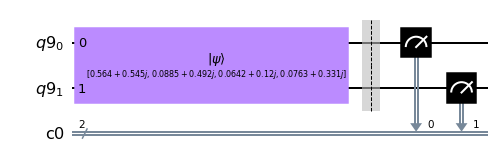

In [4]:
init = Initialize(desired_vector)
init_circ = init.gates_to_uncompute().inverse()
init_circ.draw('mpl')

qr = QuantumRegister(n)
cr = ClassicalRegister(n)
qc = QuantumCircuit(qr, cr)

qc.initialize(desired_vector, qr)
qc.barrier()
qc.measure(qr, cr)

init_circ = qc
init_circ.draw('mpl')

In [5]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(init_circ, backend)
init_state = job.result().get_statevector(init_circ)

print(state_fidelity(desired_vector,init_state))

0.615966111135405


In [6]:
circs = []
depths = []

n_iter = 10

for _ in range(n_iter):
    new_circ = transpile(init_circ,fake_machine,optimization_level=3)
    circs.append(new_circ)
    depths.append(new_circ.depth())
    
#init_circ.draw('mpl')
    
#plt.figure(figsize=(8, 6))
#plt.hist(depths, bins=list(range(min(depths),max(depths)+2)), align='left', color='#AC557C')
#plt.xlabel('Depth', fontsize=14)
#plt.ylabel('Counts', fontsize=14);


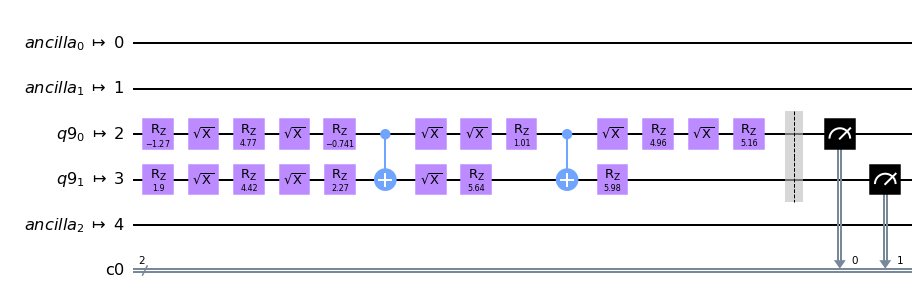

In [7]:
best_init_circ = circs[np.argmin(depths)]
best_init_circ.draw('mpl')

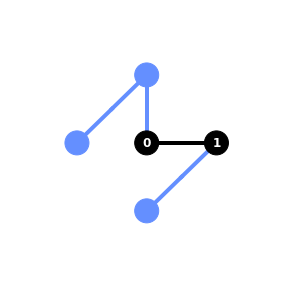

In [8]:
plot_circuit_layout(best_init_circ,fake_machine)

In [9]:
#machine_simulator = Aer.get_backend('qasm_simulator')

#best_init_circ.save_density_matrix()

#init_circ.save_density_matrix()



#for i in range(n_iter):
#    circs[i].remove_final_measurements()
#    circs[i].save_density_matrix()

mean fidelity: 1.0000000000000002


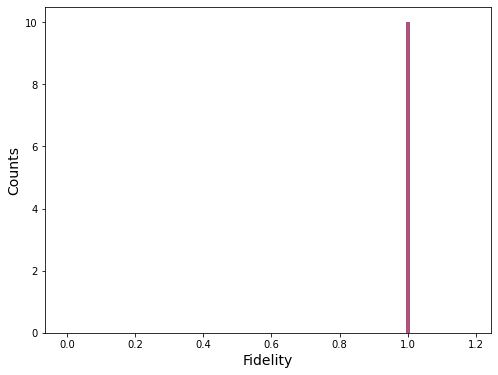

In [10]:
machine_simulator = Aer.get_backend('qasm_simulator')

#best_init_circ.snapshot_density_matrix('final')
#best_init_circ.save_density_matrix()

fidelities = []



n_shots = n_iter
pad_vectors = []

for i in range(n_iter):
    
    qubit_pattern = list(circs[i]._layout.get_virtual_bits().values()) # How virtual bits map to physical bits
    n_phys = len(qubit_pattern) # n of physical bits


    perm = [0,1,2,3,4]
    if (n < 3) :
        for j in range(n_phys):
            perm[qubit_pattern[j]] = j
    else:
        for op, qubits, clbits in circs[i].data:
            if op.name == 'measure':
                perm[qubits[0].index] = clbits[0].index
    circs[i].remove_final_measurements()
    circs[i].save_density_matrix()
    
    qubit_pattern = perm
    aug_desired_vector = desired_vector

    for k in range(n_phys-n):
        aug_desired_vector = np.kron([1,0],aug_desired_vector) #Kronecker product


    perm_circ = Permutation(n_phys, qubit_pattern) # Creating a circuit for qubit mapping
    perm_unitary = Operator(perm_circ) # Matrix for the said circuit

    perm_aug_desired_vector = perm_unitary.data @ aug_desired_vector
    pad_vectors.append(perm_aug_desired_vector)

#from itertools import permutations
#p = list(permutations(range(5), 5))
#for i in range(n_iter):
#    for j in range(factorial(5)):
#        perm_circ = Permutation(n_phys, p[j])
#        perm_unitary = Operator(perm_circ)
#        perm_aug_desired_vector = perm_unitary.data @ aug_desired_vector
#        fid = state_fidelity(perm_aug_desired_vector,execute(circs[i], machine_simulator, shots=1).result().data()['density_matrix'])
#        #fid = state_fidelity(perm_aug_desired_vector,execute(circs[i], backend).result().get_statevector(circs[i]))
#        if (1-fid < 0.01):
#            print()
#            print("circuit " + str(i))
#            print(p[j])
#            print(qubit_pattern)
#            print(fid)




#print(perm_aug_desired_vector)

#print("RESULT")
#job = execute(best_init_circ,backend,shots=1).result()
#print(job)
for i in range(n_shots):
    result = execute(circs[i],machine_simulator,shots=1).result()
#    job = execute(circs[i],backend)
    #print(result)
#    noisy_dens_matr = DensityMatrix(result.data()['snapshots']['density_matrix']['final'][0]['value'],n_phys*(2,))
#    noisy_dens_matr = result.data()['snapshots']['density_matrix']['final'][0]['value']
#    noisy_dens_matr = DensityMatrix(result.data()['density_matrix'],n_phys*(2,))
    noisy_dens_matr = result.data()['density_matrix']
#    noisy_dens_matr = job.result().get_statevector(circs[i])

    #print(noisy_dens_matr)
    fid = state_fidelity(pad_vectors[i],noisy_dens_matr)
    fidelities.append(fid)
    #print(fid)
    
#print(noisy_dens_matr)
mean_fidelity = sum(fidelities)/len(fidelities)
print("mean fidelity: " + str(mean_fidelity))

plt.figure(figsize=(8, 6))
plt.hist(fidelities, bins=list(np.arange(0,1.2,0.01)), align='left', color='#AC557C')
plt.xlabel('Fidelity', fontsize=14)
plt.ylabel('Counts', fontsize=14);

In [11]:
machine_simulator = QasmSimulator.from_backend(fake_machine)

#meas = ClassicalRegister(n)

#best_init_circ.add_register(meas)

best_init_circ.measure(list(range(n)), list(range(n)))

result_noise = execute(best_init_circ, machine_simulator).result()
counts_noise = result_noise.get_counts(best_init_circ)
plot_histogram(counts_noise, title="Counts for initialized state with device noise model")

CircuitError: 'Index out of range.'

In [ ]:
print(best_init_circ._layout.get_virtual_bits().values())
best_init_circ.draw('mpl')

In [ ]:
fake_machine

In [ ]:
pattern = list(best_init_circ._layout.get_virtual_bits().values())
print(pattern)

In [ ]:
augmented_desired_vector = desired_vector

for k in range(2):
    augmented_desired_vector = np.kron(augmented_desired_vector,[1,0])

permutation_circ = Permutation(5,[2,1,0,3,4])
permutation_unitary = Operator(permutation_circ)

perm_vector = permutation_unitary.data @ augmented_desired_vector

print(perm_vector)

In [ ]:
permutation_unitary.data

In [ ]:
augmented_desired_vector

In [ ]:
print(augmented_desired_vector)
print(permutation_unitary.data @ augmented_desired_vector)

In [ ]:
backend = BasicAer.get_backend('statevector_simulator')
for circ in circs:

    job = execute(circ, backend)
    init_state = job.result().get_statevector(circ)
    
    print(absolute(vdot(desired_vector, init_state))**2)
    print(state_fidelity(desired_vector,init_state))
    print(list(circ._layout.get_virtual_bits().values()))

# 